# Ripetizione dell'esperimento sui dati cinesi

In [161]:
def compute_best_k(x,y,occurrencies, plot=False,points=1000,sf=0.9):
    import numpy as np
    if len(x)<5:
        return max(1, round(np.sqrt(occurrencies/2)))
    
    from scipy.interpolate import interp1d
    from scipy.interpolate import UnivariateSpline
    spl = UnivariateSpline(x, y)
    spl.set_smoothing_factor(sf)
    xs = np.linspace(min(x), max(x), points)
    ys = spl(xs)
    idx_better_k=get_change_point(xs, ys)
    if plot:
        import pylab
        pylab.plot(xs,ys)
        
        pylab.scatter(xs[idx_better_k],ys[idx_better_k],s=20, marker='o')
        pylab.text(xs[idx_better_k],ys[idx_better_k],"bestK %s" %(np.round(xs[idx_better_k])))
        return int(np.round(xs[idx_better_k])),pylab
    return int(np.round(xs[idx_better_k]))

def get_change_point(x, y):
    """
        Scelta del K migliore
        ::param x: lista di valori di K
        ::param y: lista di valori di SSE
    """
    import math
    max_d = -float('infinity')
    index = 0

    for i in range(0, len(x)):
        c = closest_point_on_segment(a=[x[0], y[0]], b=[x[len(x)-1], y[len(y)-1]], p=[x[i], y[i]])
        d = math.sqrt((c[0]-x[i])**2 + (c[1]-y[i])**2)
        if d > max_d:
            max_d = d
            index = i
    
    return index

def closest_point_on_segment(a, b, p):
    sx1 = a[0]
    sx2 = b[0]
    sy1 = a[1]
    sy2 = b[1]
    px = p[0]
    py = p[1]

    x_delta = sx2 - sx1
    y_delta = sy2 - sy1

    if x_delta == 0 and y_delta == 0:
        return p

    u = ((px - sx1) * x_delta + (py - sy1) * y_delta) / (x_delta * x_delta + y_delta *  y_delta)
    if u < 0:
        closest_point = a
    elif u > 1:
        closest_point = b
    else:
        cp_x = sx1 + u * x_delta
        cp_y = sy1 + u * y_delta
        closest_point = [cp_x, cp_y]

    return closest_point
	
	

def bench_k_means(estimator, name, data,distance_function=None):
    from sklearn import metrics
    from sklearn.metrics import silhouette_samples, silhouette_score
    import time
    t0 = time.time()
    if distance_function:
        estimator.fit(data,distance_function)
    else:
        estimator.fit(data)
    #cluster_labels = estimator.fit_predict(data)
    #silhouette_score_ = silhouette_score(data, cluster_labels)
    
    inertia=estimator.inertia_
    duration=time.time() - t0
    return {'inertia':inertia,'duration':duration, 'estimator':estimator}#,'silhouette':silhouette_score_}

def export_results(K,label):
    """
        Esportazione del risultato dei vari run dell'algoritmo di clustering al variare di K
        ::param K dataframe: risultato dell'esecuzione <K:{tempo(sec), inertia}
        ::label text: etichetta da inserire nel nome del file di output
        
        
    """
    
    import pandas as pd
    import os.path
    import pylab
    output_file='../experiments/20171020_epj/scelta_k_%s.csv' %(label)
    if not(os.path.isfile(output_file)):
        f=open (output_file,'wb')
        f.write('k;execution(seconds);inertia\n')
        f.flush()
        f.close()
    
    scelta_k=pd.DataFrame.from_dict(K,orient='index')
    scelta_k[['duration','inertia']].to_csv(output_file,sep=';',decimal='.',mode='a',header=False)
    
    scelta_k=pd.read_csv(output_file,sep=';',decimal='.')
    x=scelta_k['k']
    y=scelta_k['inertia']
    
    pylab.plot(x,y)
    pylab.xticks(fontsize=18)
    pylab.yticks(fontsize=18)
    pylab.xlabel('K', fontsize=20)
    pylab.ylabel('SSE',fontsize=20)
    pylab.subplots_adjust(bottom=0.13)
    pylab.title(label,fontsize=22)
    pylab.tight_layout()
    pylab.savefig('../experiments/20171020_epj/scelta_k_%s.png' %(label),dpi=150)
    #l'intestazione del file
    pylab.clf()
    pylab.close()
    
def process_footprint(data,tests,log=False):
    from sklearn.cluster import MiniBatchKMeans
    #KMeans(init='k-means++', n_clusters=k, n_init=10)
    import datetime
    K={}
    for k in tests:
        if k<=len(data):
            if log:
                print "%s: processing %s" %(datetime.datetime.now(),k)
            K[k]=bench_k_means(MiniBatchKMeans(init='k-means++', n_clusters=k, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0),name="k-means++", data=data)

    return K

## Staging area

In [162]:
def process_user(user):
    """
        user dict: contiene gli acquisti fatti dagli utenti durante gli anni
        return uid: id utente
        return anni: dizionario contentente il vettore formato sociometro con d=7(ampiezza finestra) e t=1 (fascia temporale)
    """
    uid=user['customer_id']
    data=user['data']
    acquisti=data.keys()
    anni=set([el.split('_')[0] for el in acquisti])
    anni={int(anno):{} for anno in list(anni)}
    for acquisto in acquisti:
        acquisto=data[acquisto]
        week=datetime.datetime(acquisto['anno'],acquisto['mese_n'],acquisto['giorno_n']).isocalendar()[1]
        weekday=datetime.datetime(acquisto['anno'],acquisto['mese_n'],acquisto['giorno_n']).weekday()
        if not(week in anni[acquisto['anno']]):
            anni[acquisto['anno']][week]=np.array([0]*7)
        anni[acquisto['anno']][week][weekday]+=len(acquisto['basket'])
    return uid,anni

## Parsing dataset cinesi

In [165]:
#reading raw data
import json
import numpy as np
import datetime
import pylab
#file='epj_coop.csv'
file='tafeng'
raw_data='../data/dataset_cinesi/%s.json' %(file)

individual_footprint="%s.individual_footprint" %(raw_data)
individual_clusters="%s.clusters" %(individual_footprint)
individual_labels="%s.labels" %(individual_footprint)

collective_clusters="%s.collective_footprint.clusters" %(raw_data)
collective_labels="%s.collective_footprint.labels" %(raw_data)

In [166]:
fi=open(raw_data)
profiles={}
for rec in fi:
    user=json.loads(rec)
    results=process_user(user)
    profiles[results[0]]=results[1]

#exporting individual footprint   <customer_id;year;week;profile_id;size;t1... tn >
fw=open(individual_footprint,'wb')
fw.write('customer_id;year;week;profile_id;size;d0;d1;d2;d3;d4;d5;d6\n')
footprints=0
for uid in profiles:
    profile_id=0
    for year in profiles[uid]:
        for week in profiles[uid][year]:
            d=profiles[uid][year][week]
            fw.write('%s;%s;%s;%s;%s;%s;%s;%s;%s;%s;%s;%s\n' %(uid,year,week,profile_id,sum(d)
                                                                             ,d[0],d[1],d[2],d[3],d[4],d[5],d[6]))
            profile_id+=1
    footprints+=profile_id
    fw.flush()
fw.close()
print "number of footprint", footprints

number of footprint 99739


## Individual Clustering

In [167]:
#<customer_id;year;week;profile_id;size;t1... tn >
import datetime
f=open(individual_footprint)
fw=open(individual_clusters,'wb')  #uid,cluster_id,centroid
fw2=open(individual_labels,'wb') #uid,year,week,cluster_id,profile
f.readline()
data=[] #buffer
curr_uid=-1
log=False
done=0
footprints_clustered=0
footprints_clusters=0
for rec in f: #reading individual footprint
    rec=rec.strip().split(';')
    uid=rec[0]
    year=rec[1]
    week=rec[2]
    profile=np.array([float(el) for el in rec[5:]])
    if curr_uid!=uid and curr_uid!=-1:
        #individual clustering
        if len(data)>2:
            
            to_cluster=[el[1] for el in data]
            K=process_footprint(to_cluster,np.arange(2,50))
          
            #choose k
            x=K.keys()
            y=[K[k]['inertia'] for k in K]
            best_k=compute_best_k(x,y,len(to_cluster))
            if log:
                print "clustering",curr_uid,"len data",len(data),"best k",best_k
            
            #clustering
            if best_k==1:
                #to few records
                cluster_centers_=[np.average(to_cluster,axis=0)]
                labels_=[0]*len(to_cluster)
            else:
                cluster_centers_=K[best_k]['estimator'].cluster_centers_
                labels_=K[best_k]['estimator'].labels_
            
            #export individual centroids
            for i in np.arange(len(cluster_centers_)):
                string="%s;%s;%s\n"%(curr_uid,i,';'.join([str(el) for el in cluster_centers_[i]])) #uid,cluster_id,centroid
                fw.write(string)
                footprints_clusters+=1
            fw.flush()

            #export original data and labels
            for i in np.arange(len(data)):
                uid=data[i][0]
                profile=data[i][1]
                label=labels_[i]
                string="%s;%s;%s;%s;%s\n" %(uid[0],uid[1],uid[2],label
                                            ,';'.join([str(el) for el in profile]))#uid,year,week,cluster_id,profile
                fw2.write(string)
                footprints_clustered+=1
            fw2.flush()
            
            done+=1
            if done%1000==0:
                print datetime.datetime.now(),done, "footprints_clustered",footprints_clustered, "clusters produced",footprints_clusters
                                    
        data=[] #when change the userid and we empty the buffer
        
    curr_uid=uid
    data.append(((uid,year,week),profile))
fw.close()
fw2.close()
    
print datetime.datetime.now(),done, "footprints_clustered",footprints_clustered, "clusters produced",footprints_clusters


2017-10-26 10:58:06.652000 1000 footprints_clustered 5538 clusters produced 2222
2017-10-26 10:59:28.772000 2000 footprints_clustered 11659 clusters produced 4680
2017-10-26 11:00:35.674000 3000 footprints_clustered 17183 clusters produced 6962
2017-10-26 11:01:44.110000 4000 footprints_clustered 22816 clusters produced 9327
2017-10-26 11:02:54.842000 5000 footprints_clustered 28517 clusters produced 11681
2017-10-26 11:04:00.975000 6000 footprints_clustered 34045 clusters produced 13954
2017-10-26 11:05:03.314000 7000 footprints_clustered 39357 clusters produced 16075
2017-10-26 11:06:09.649000 8000 footprints_clustered 44815 clusters produced 18211
2017-10-26 11:07:14.986000 9000 footprints_clustered 50299 clusters produced 20415
2017-10-26 11:08:22.172000 10000 footprints_clustered 55861 clusters produced 22723
2017-10-26 11:09:28.477000 11000 footprints_clustered 61367 clusters produced 24975
2017-10-26 11:10:26.342000 11927 footprints_clustered 66325 clusters produced 26947


In [168]:
len(profile)

7

# Collective clustering

In [169]:
f=open(individual_clusters) #uid,cluster_id,profile
data=[]
for row in f:
    row=row.strip().split(';')
    uid=row[0]
    cluster_id=row[1]
    individual_profile=np.array([float(el) for el in row[2:]])
    data.append(((uid,cluster_id),individual_profile))

to_cluster=[el[1] for el in data]
tests=np.arange(2,50)
tests=list(tests)+list(np.arange(50,150,5))
K=process_footprint(to_cluster,tests,log=True)

import pickle
pickle.dump( K, open( "%s.models.p" %(raw_data), "wb" ) )


2017-10-26 11:10:26.533000: processing 2
2017-10-26 11:10:26.607000: processing 3
2017-10-26 11:10:26.660000: processing 4
2017-10-26 11:10:26.715000: processing 5
2017-10-26 11:10:26.783000: processing 6
2017-10-26 11:10:26.856000: processing 7
2017-10-26 11:10:26.930000: processing 8
2017-10-26 11:10:27.049000: processing 9
2017-10-26 11:10:27.171000: processing 10
2017-10-26 11:10:27.298000: processing 11
2017-10-26 11:10:27.389000: processing 12
2017-10-26 11:10:27.480000: processing 13
2017-10-26 11:10:27.583000: processing 14
2017-10-26 11:10:27.705000: processing 15
2017-10-26 11:10:27.799000: processing 16
2017-10-26 11:10:27.961000: processing 17
2017-10-26 11:10:28.062000: processing 18
2017-10-26 11:10:28.166000: processing 19
2017-10-26 11:10:28.272000: processing 20
2017-10-26 11:10:28.388000: processing 21
2017-10-26 11:10:28.531000: processing 22
2017-10-26 11:10:28.735000: processing 23
2017-10-26 11:10:28.990000: processing 24
2017-10-26 11:10:29.251000: processing 25


## Choosing k for global clustering

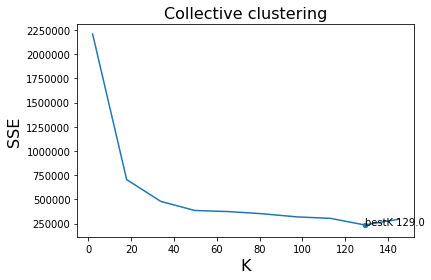

In [170]:
#choose K for global clustering 
%matplotlib inline
x=sorted(K.keys())
y=[K[k]['inertia'] for k in x]
best_k,pylab=compute_best_k(x,y,len(to_cluster),plot=True,points=10)

best_k=15 #a mano
pylab.title("Collective clustering",fontsize=16)
pylab.ylabel("SSE",fontsize=16)
pylab.xlabel("K",fontsize=16)
pylab.tight_layout()
pylab.savefig('%s.png' %(raw_data),dpi=200)

import pandas as pd
df_sse=pd.DataFrame([x,y]).T
df_sse.columns=['x','y']
df_sse.to_csv('%s.png.sse.csv' %(raw_data),index=False)

## Exporting results

In [171]:
cluster_centers_=K[best_k]['estimator'].cluster_centers_
labels_=K[best_k]['estimator'].labels_
fw=open(collective_clusters,"wb")
fw2=open(collective_labels,"wb")
#export individual centroids
for i in np.arange(len(cluster_centers_)):
    string="%s;%s\n"%(i,';'.join([str(el) for el in cluster_centers_[i]])) #cluster_id,centroid
    fw.write(string)
fw.flush()

#export original data and labels
for i in np.arange(len(data)):
    uid=data[i][0]
    profile=data[i][1]
    label=labels_[i]
    string="%s;%s;%s;%s\n" %(uid[0],uid[1],label
                                ,';'.join([str(el) for el in profile]))#uid,individual_cluster_id,collective_cluster_id,profile
    fw2.write(string)
fw2.flush()


In [172]:
best_k

15

# Dendogram

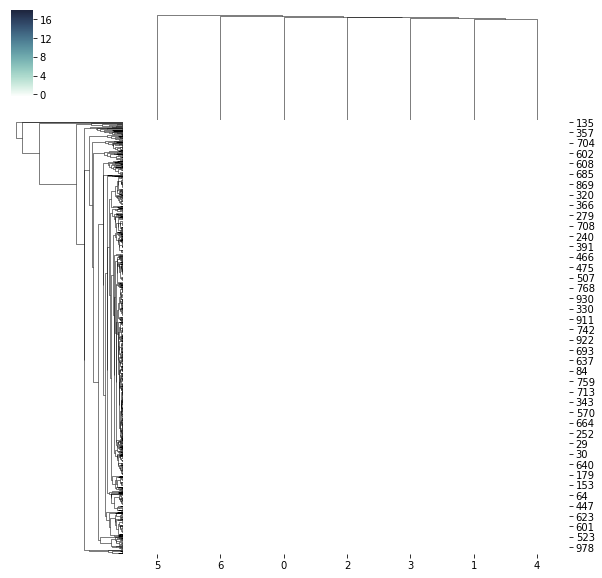

In [173]:
%matplotlib inline
import pylab
import matplotlib.cm as cm
import seaborn as sn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

f=open(individual_clusters) #uid,cluster_id,profile
data=[]
for row in f:
    row=row.strip().split(';')
    uid=row[0]
    cluster_id=row[1]
    individual_profile=np.array([float(el) for el in row[2:]])
    data.append(((uid,cluster_id),individual_profile))

to_cluster=[el[1] for el in data]

X_scaled = scaler.fit_transform( to_cluster[:1000] )

cmap = sn.cubehelix_palette(as_cmap=True, rot=-.3, light=1)
sn.clustermap(X_scaled, cmap=cmap, linewidths=.5)
pylab.savefig("%s.dendogram.png" %(raw_data),dpi=200)

# Silhouette

('For n_clusters =', 5, 'The average silhouette_score is :', 0.35894194014557818)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.3823078778205547)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.40676742453607739)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.43396010813451774)
('For n_clusters =', 9, 'The average silhouette_score is :', 0.37629704307284911)
('For n_clusters =', 10, 'The average silhouette_score is :', 0.3753892284145332)
('For n_clusters =', 11, 'The average silhouette_score is :', 0.38745119849221366)
('For n_clusters =', 12, 'The average silhouette_score is :', 0.36805868028507666)
('For n_clusters =', 13, 'The average silhouette_score is :', 0.37658968357827594)
('For n_clusters =', 14, 'The average silhouette_score is :', 0.38168265543513846)
('For n_clusters =', 15, 'The average silhouette_score is :', 0.38080931350953118)
('For n_clusters =', 16, 'The average silhouette_score is :', 0.36312992177193598)
('For n_clu

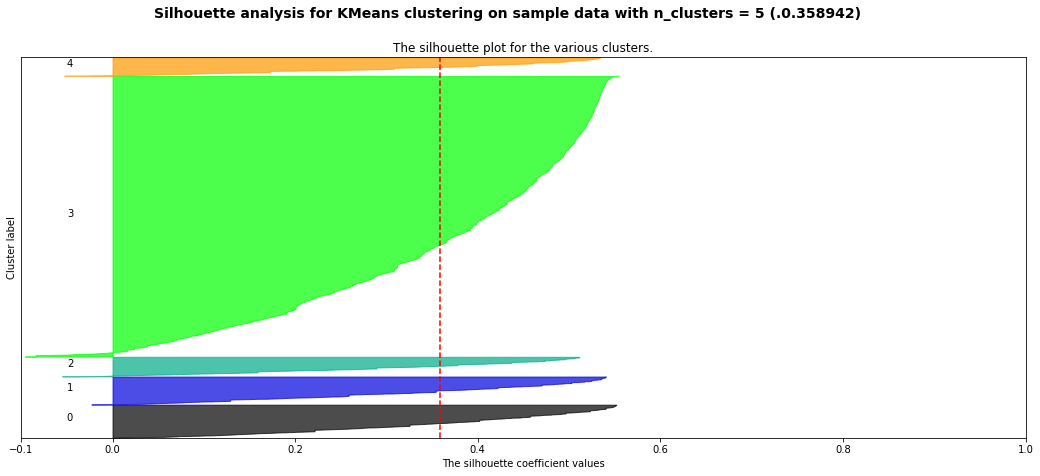

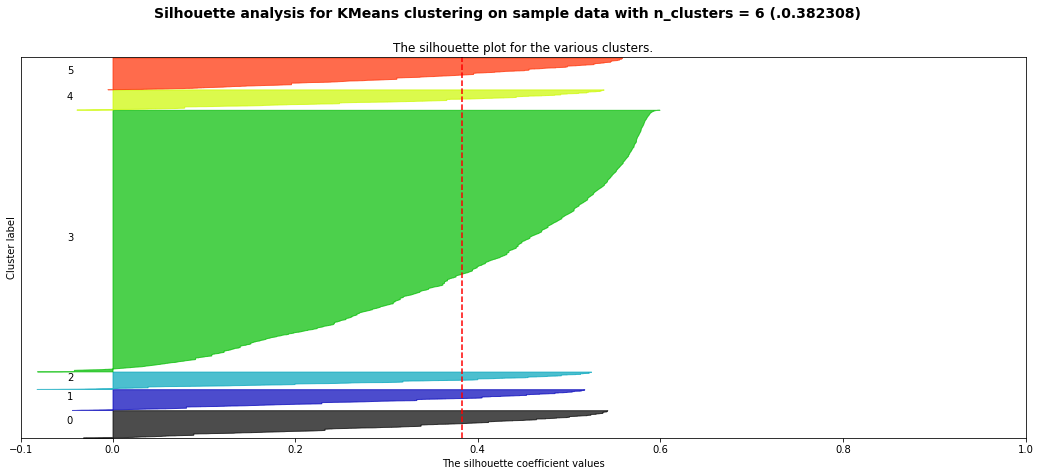

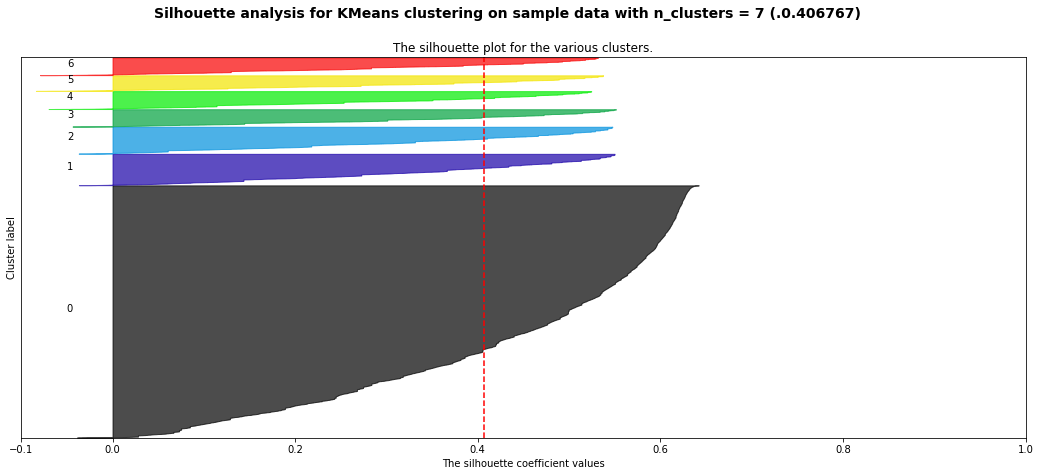

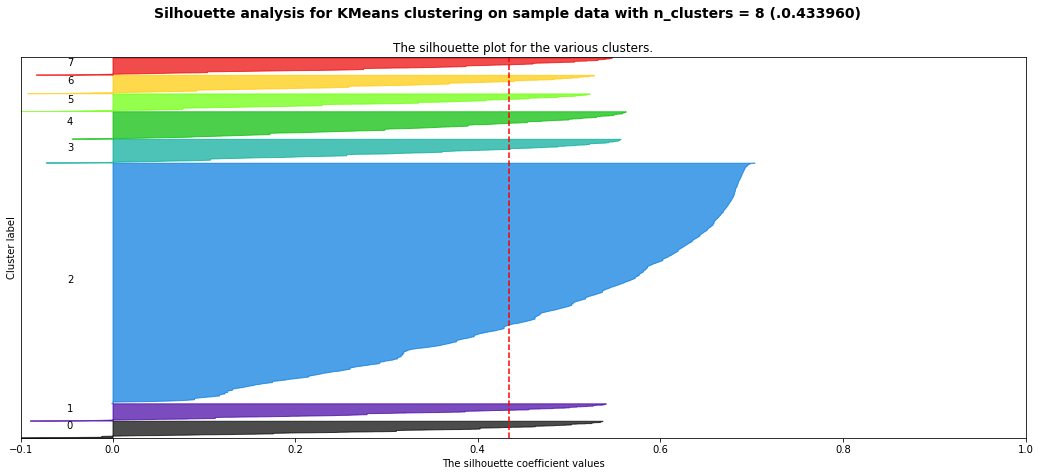

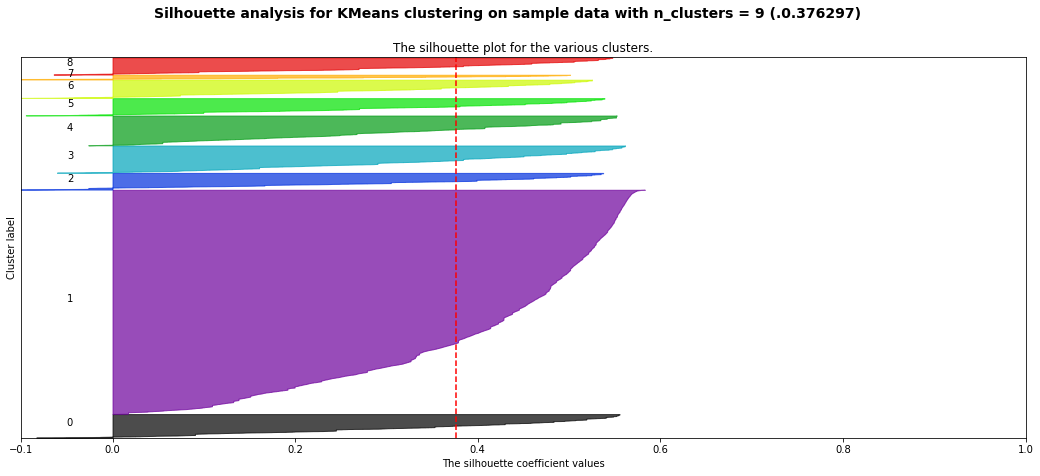

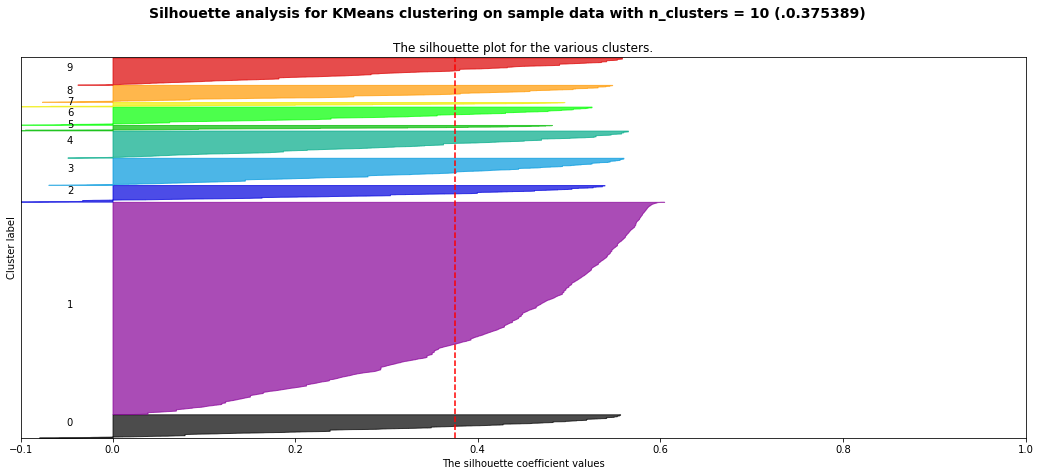

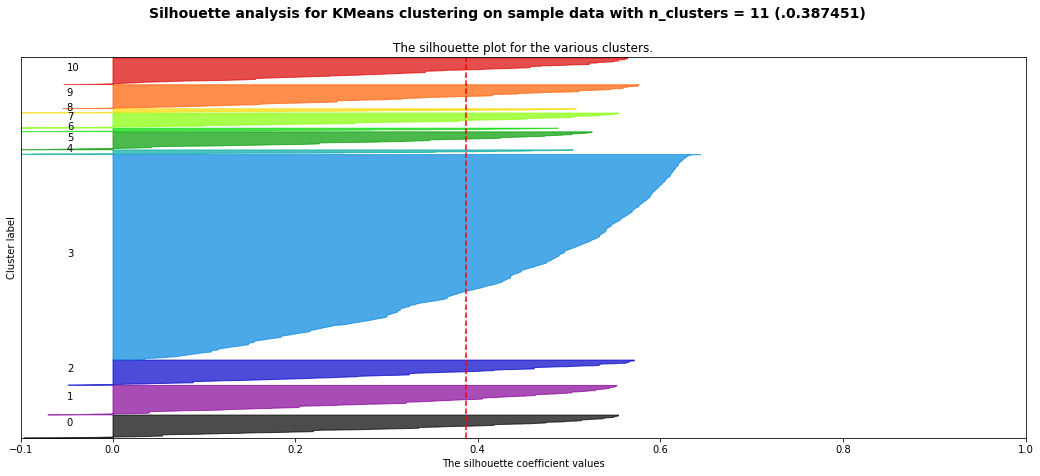

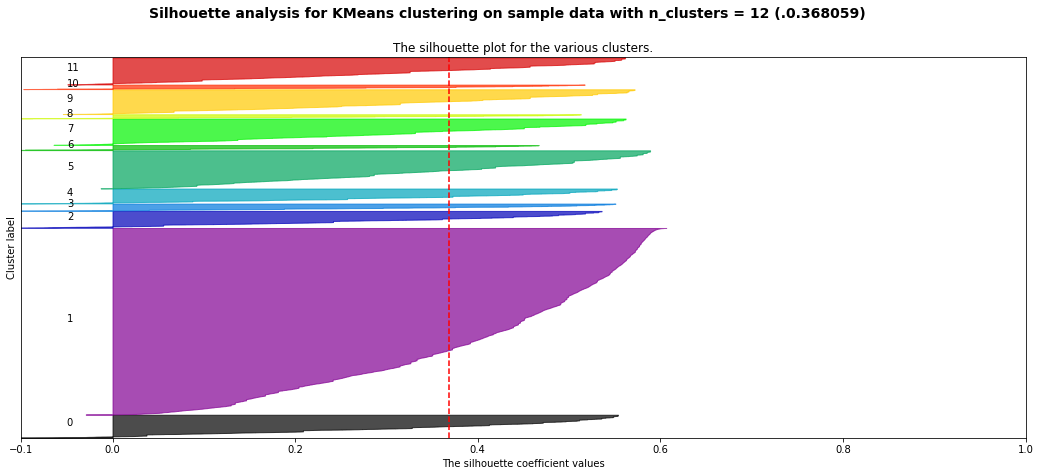

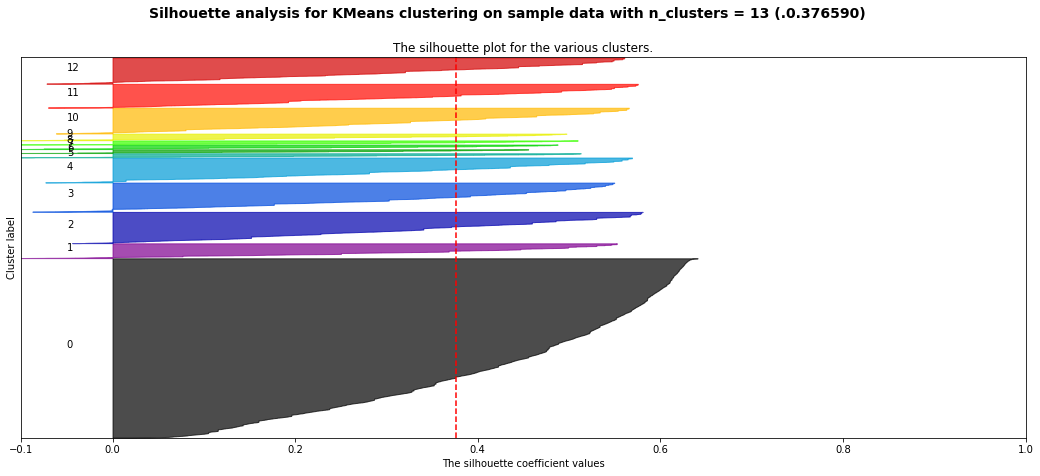

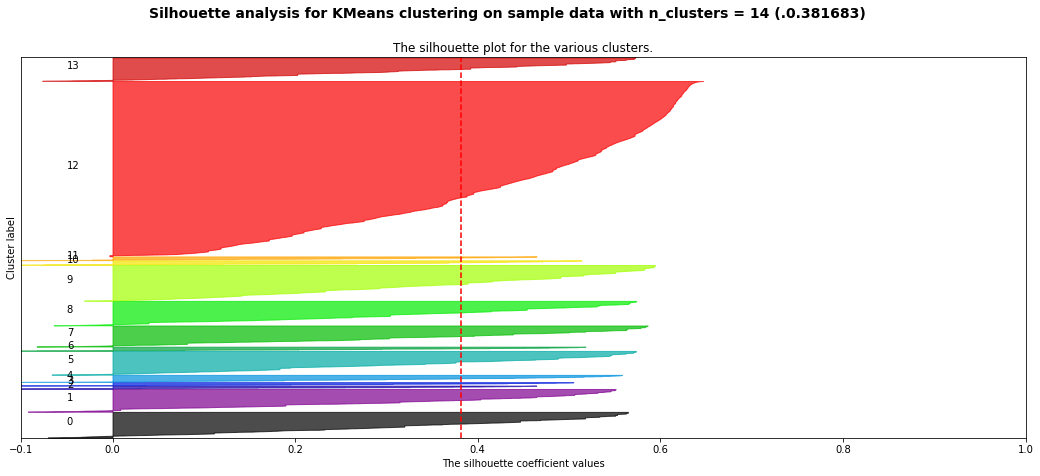

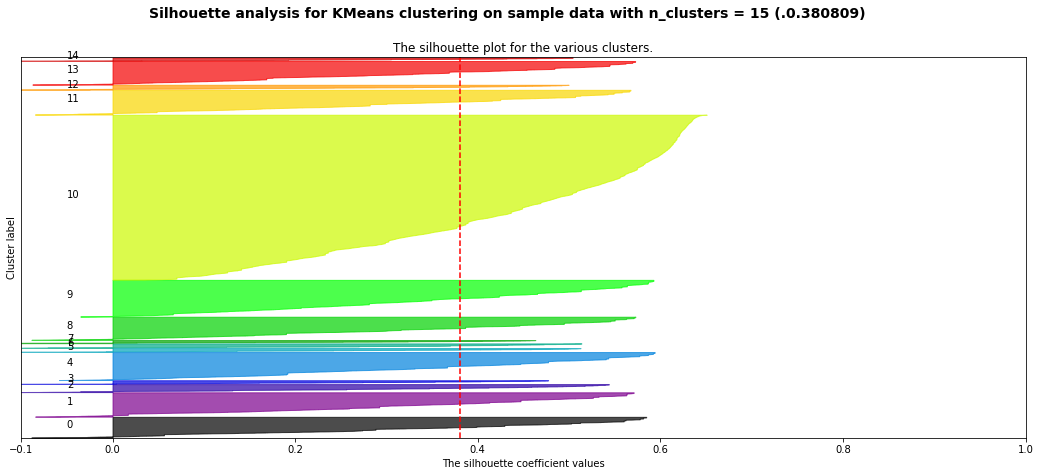

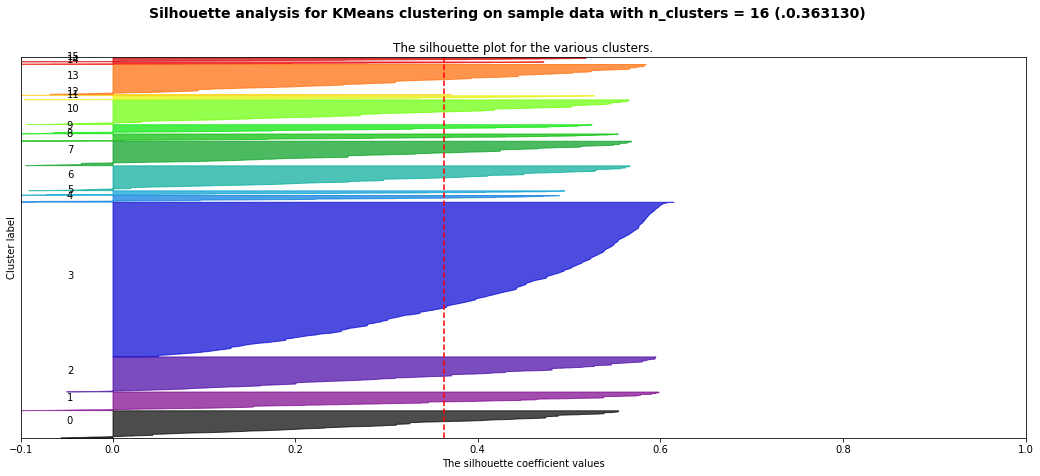

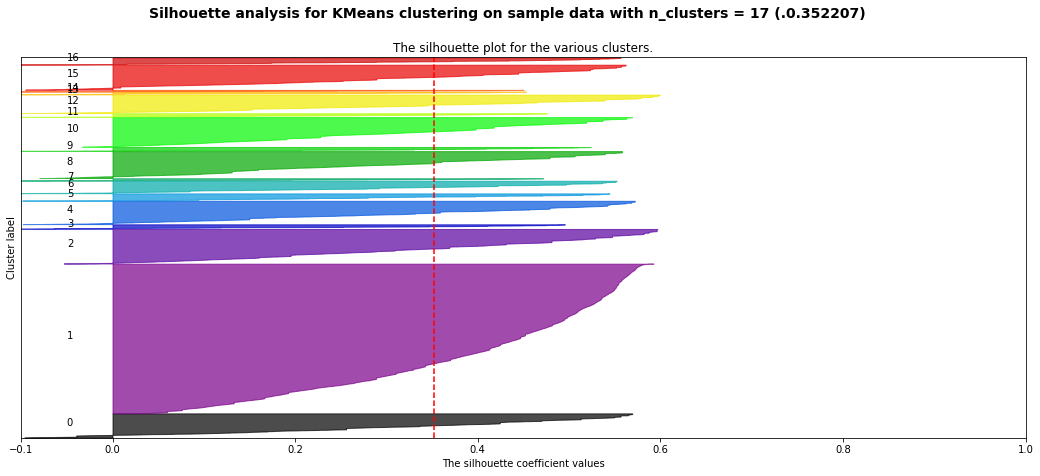

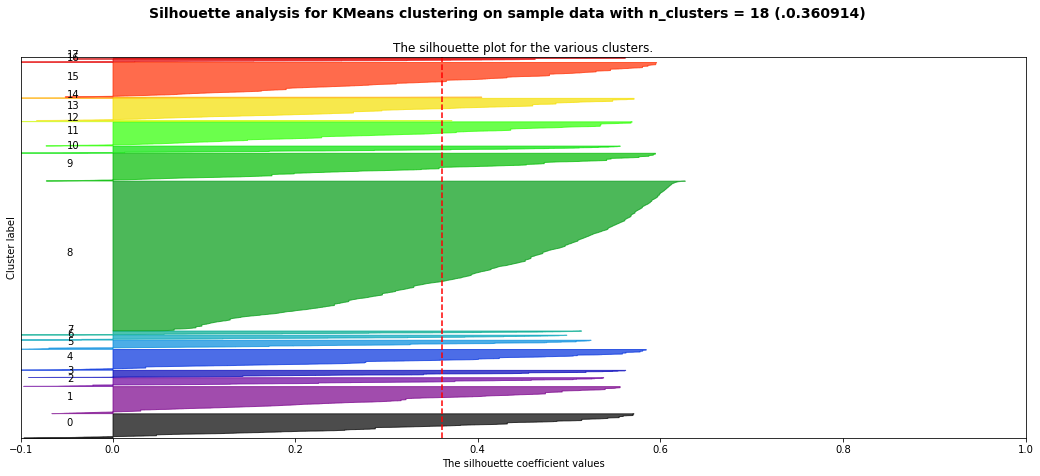

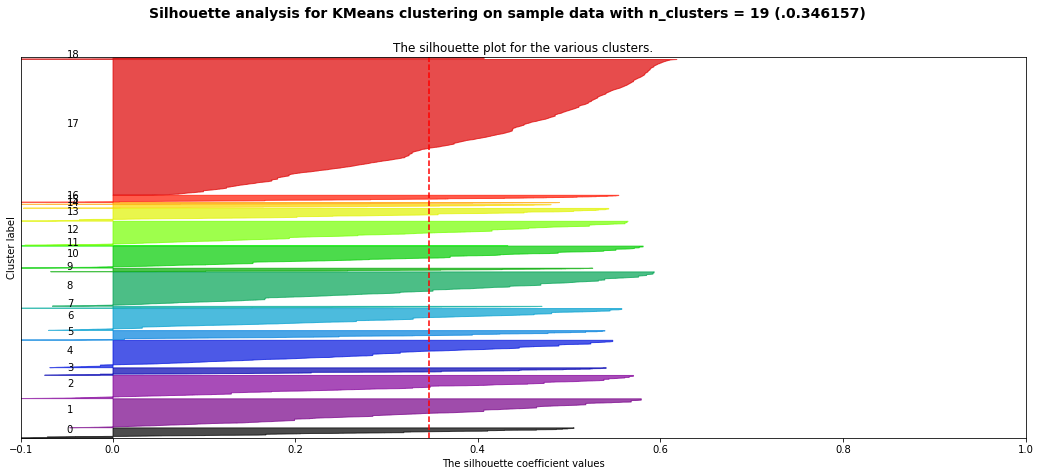

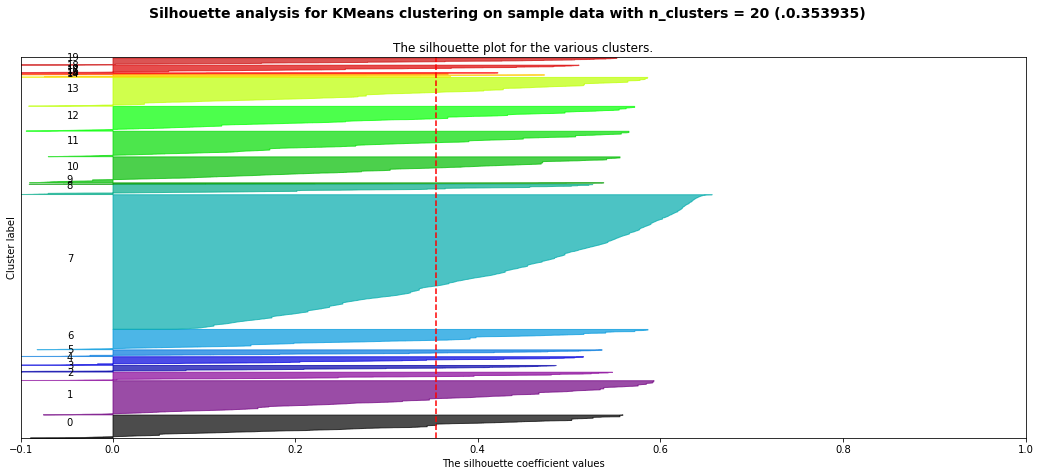

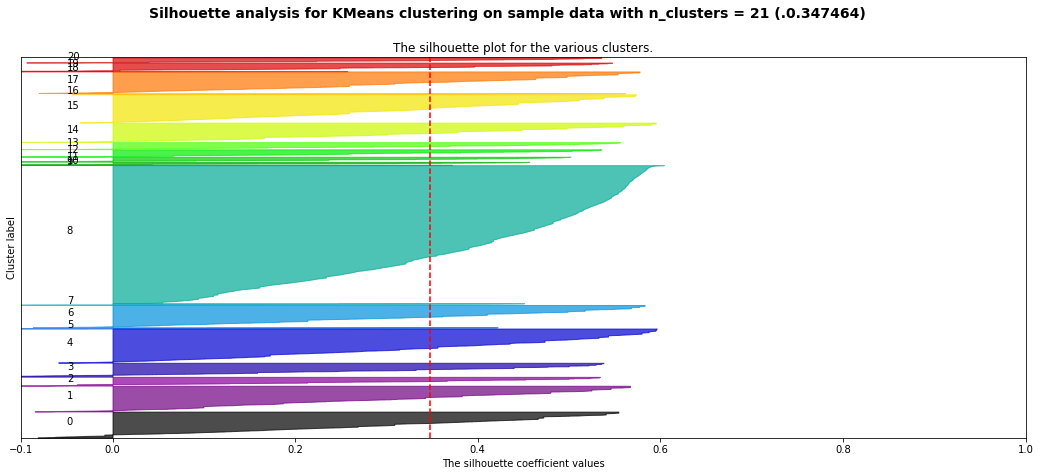

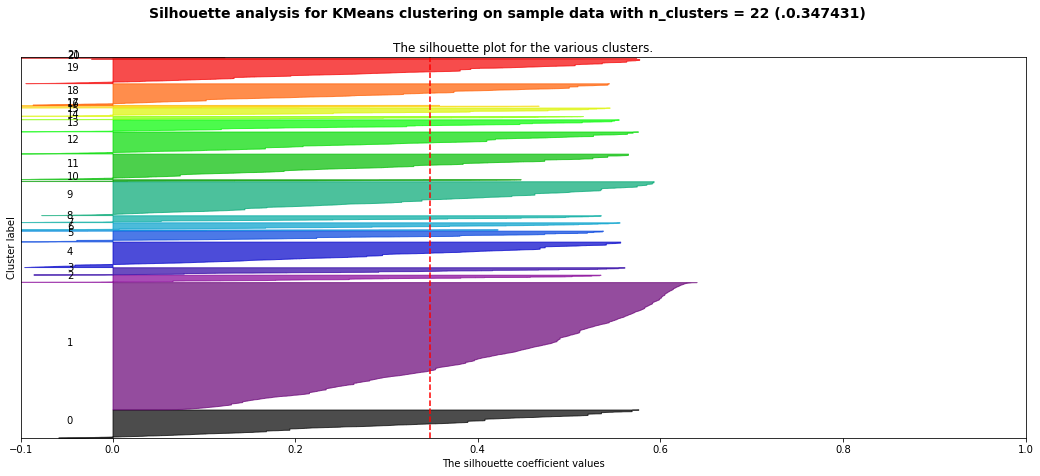

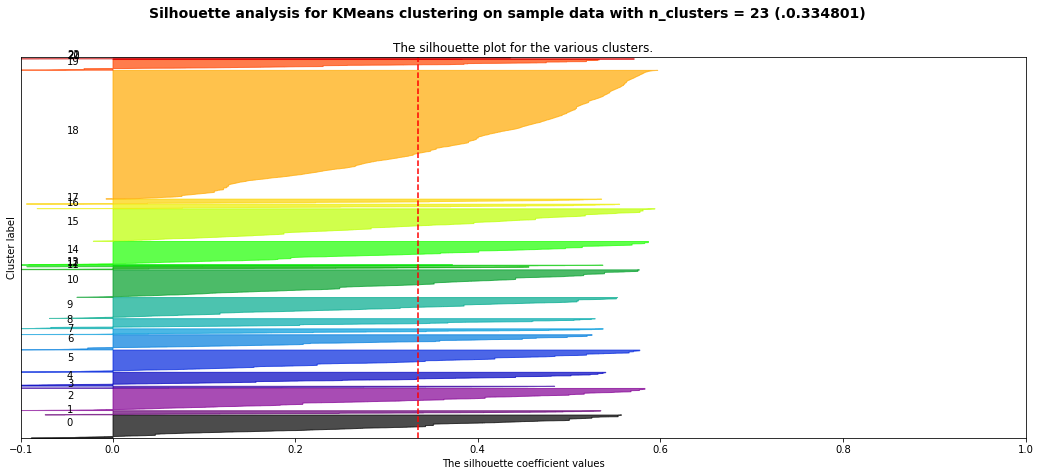

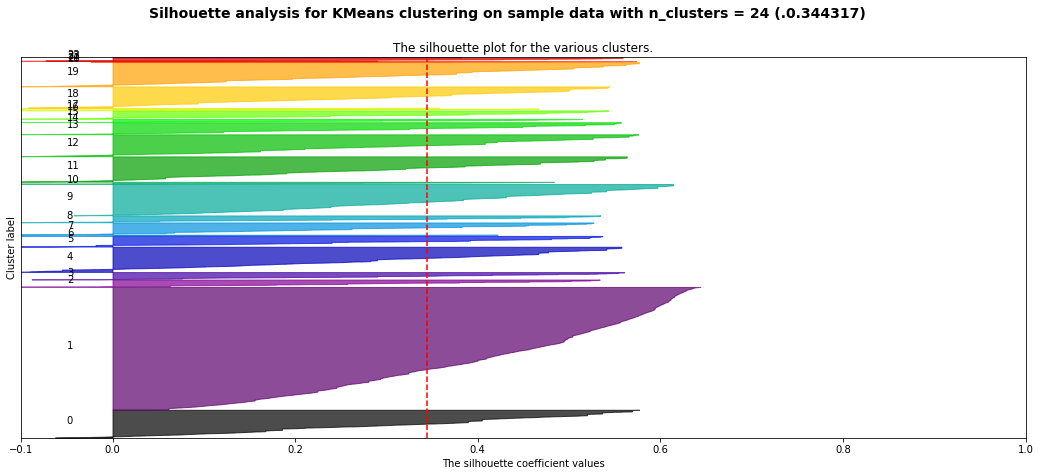

In [174]:
%matplotlib inline
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import seaborn as sn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from random import shuffle
f=open(individual_clusters) #uid,cluster_id,profile
data=[]
for row in f:
    row=row.strip().split(';')
    uid=row[0]
    cluster_id=row[1]
    individual_profile=np.array([float(el) for el in row[2:]])
    data.append(((uid,cluster_id),individual_profile))

to_cluster=[el[1] for el in data]
shuffle(to_cluster)
X_scaled = scaler.fit_transform( to_cluster[:20000] )
from sklearn.cluster import KMeans

import pylab
window=10
cluster_range = range( best_k-window, best_k+window )
Silhouette=[]
for n_clusters in cluster_range:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = pylab.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict( X_scaled )

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    Silhouette.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    pylab.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d (.%3f)" % (n_clusters,silhouette_avg)),
               fontsize=14, fontweight='bold')

    pylab.savefig("%s.silhouette-k%s.png" %(raw_data,n_clusters),dpi=200)

# Valutazione sulla scelta del K in base ai diversi valori di silhouette

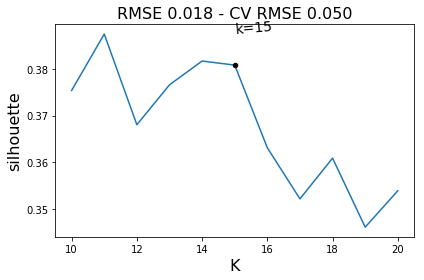

In [183]:
silhouette_best_k_idx=cluster_range.index(best_k)
from sklearn.metrics import mean_squared_error
from math import sqrt
#window=10
min_idx=silhouette_best_k_idx-(window/2)
max_idx=silhouette_best_k_idx+(window/2)+1
rmse = sqrt(mean_squared_error(Silhouette[min_idx:max_idx]
                              ,np.array([Silhouette[silhouette_best_k_idx]]*(len(Silhouette[min_idx:max_idx])))))
cv_rmse=rmse/np.mean(Silhouette[min_idx:max_idx])
title= "RMSE %.3f - CV RMSE %.3f" %(rmse, cv_rmse)

import pylab
k =np.arange( cluster_range[min_idx], cluster_range[max_idx] )
pylab.plot(k,Silhouette[min_idx:max_idx])
pylab.title(title,fontsize=16)
pylab.xlabel('K',fontsize=16)
pylab.ylabel('silhouette',fontsize=16)
pylab.tight_layout()
x=best_k
y=Silhouette[cluster_range.index(best_k)]
pylab.tight_layout()
pylab.scatter(x,y,s=20, marker='o',c='black',zorder=8)
pylab.text(x,y*1.02,'k=%s' %(best_k),fontsize=14,rotation=+5)
pylab.savefig('%s.silhouette.png' %(raw_data),dpi=200)

#salvo silhouette
fw=open('%s.silhouette.csv' %(raw_data),'wb')
fw.write('k;silhouette\n')
for k_,s_ in zip(cluster_range,Silhouette):
    row="%s;%s\n" %(k_,s_)
    fw.write(row)
fw.flush()
fw.close()

# Variare della silhouette alla dimensione della finestra

In [180]:
def k_tollerance(best_k,cluster_range,Silhouette,window):
    """
        best_k: number of cluster
        cluster_range: valori di k per cui è calcolata la silhouett
        Silhouette: valori di sulhouette per un dato k definito da cluster_range
        window: finestra per cui calcolare la variazione di silhouette
        return rmse,cv_rmse
    """
    silhouette_best_k_idx=cluster_range.index(best_k)
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    min_idx=silhouette_best_k_idx-(window/2)
    max_idx=silhouette_best_k_idx+(window/2)+1
    rmse = sqrt(mean_squared_error(Silhouette[min_idx:max_idx]
                                  ,np.array([Silhouette[silhouette_best_k_idx]]*(len(Silhouette[min_idx:max_idx])))))
    cv_rmse=rmse/np.mean(Silhouette[min_idx:max_idx])
    return rmse,cv_rmse

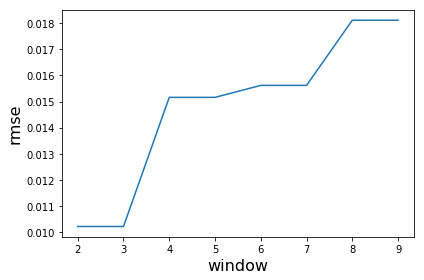

In [184]:
# caricare il file delle silhouette
W=np.arange(2,window)
qualita=[k_tollerance(best_k,cluster_range,Silhouette,window=w) for w in W]
pylab.plot(W,[el[0] for el in qualita])
pylab.xlabel('window',fontsize=16)
pylab.ylabel('rmse',fontsize=16)
pylab.tight_layout()
pylab.savefig('%s.rmse-window.png' %(raw_data),dpi=200)

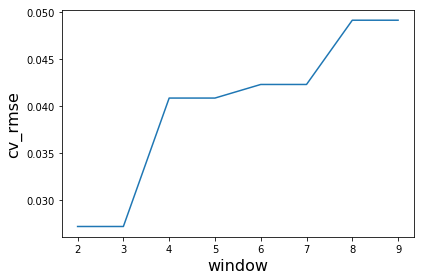

In [185]:
qualita=[k_tollerance(best_k,cluster_range,Silhouette,window=w) for w in W]
pylab.plot(W,[el[1] for el in qualita])
pylab.xlabel('window',fontsize=16)
pylab.ylabel('cv_rmse',fontsize=16)
pylab.tight_layout()
pylab.savefig('%s.rmse-cv-window.png' %(raw_data),dpi=200)